In [1]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
#### Preprocecing ###

In [3]:
jh_dir = "../../COVID-19"

In [4]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [5]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [6]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [7]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [8]:
### Data Preparation ###

In [9]:
country = 'Japan'
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-04-29')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [10]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}

In [11]:
### Model ###

In [12]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc6d31dd51996c751224e95703ac4eef NOW.


In [13]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fbc61a4e98647df601fe416f41355090 NOW.


In [14]:
# Train the model and generate samples
inits = 'random'
fit_const = sm_const.sampling(data=data, iter=iteration, init=inits)
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_bc6d31dd51996c751224e95703ac4eef.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  17.98    0.06   3.78  11.14  15.35  17.77  20.44  26.09   3842    1.0
b          0.07  1.4e-5 8.0e-4   0.07   0.07   0.07   0.07   0.07   3255    1.0
q           1.0  7.7e-6 6.2e-4    1.0    1.0    1.0    1.0    1.0   6429    1.0
NI[1]      1.43    0.01   0.87    0.1   0.77   1.33   1.97   3.43   3518    1.0
NI[2]      1.51    0.02   0.91   0.09   0.79   1.42   2.09   3.49   3366    1.0
NI[3]      1.59    0.01   0.95   0.11   0.86    1.5   2.22   3.65   4068    1.0
NI[4]      2.68    0.01   0.97   0.98   1.97   2.62   3.32   4.74   4427    1.0
NI[5]       1.8    0.02   1.05   0.13   1.01   1.69    2.5   4.02   3637    1.0
NI[6]      3.33    0.02   1.06   1.49   2.57   3.28

In [15]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits)
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_fbc61a4e98647df601fe416f41355090.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.82    0.02   1.04   0.46   1.09   1.61   2.27   4.44   2831    1.0
b_beta     0.04  1.5e-4 6.0e-3   0.03   0.04   0.04   0.05   0.05   1677    1.0
b[1]       0.26  3.2e-3   0.13   0.04   0.17   0.25   0.34   0.55   1715    1.0
b[2]       0.27  3.1e-3   0.12   0.07   0.18   0.26   0.34   0.53   1533    1.0
b[3]       0.27  3.0e-3   0.11   0.09   0.19   0.26   0.34   0.51   1389    1.0
b[4]       0.27  2.6e-3    0.1   0.11    0.2   0.26   0.33    0.5   1603    1.0
b[5]       0.27  2.4e-3    0.1    0.1    0.2   0.26   0.32   0.48   1662    1.0
b[6]       0.26  2.0e-3   0.09   0.11    0.2   0.26   0.31   0.47   2052    1.0
b[7]       0.25  1.9e-3   0.09    0.1   0.19   0.24

In [16]:
print(fit_every)

Inference for Stan model: anon_model_fbc61a4e98647df601fe416f41355090.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.82    0.02   1.04   0.46   1.09   1.61   2.27   4.44   2831    1.0
b_beta        0.04  1.5e-4 6.0e-3   0.03   0.04   0.04   0.05   0.05   1677    1.0
b[1]          0.26  3.2e-3   0.13   0.04   0.17   0.25   0.34   0.55   1715    1.0
b[2]          0.27  3.1e-3   0.12   0.07   0.18   0.26   0.34   0.53   1533    1.0
b[3]          0.27  3.0e-3   0.11   0.09   0.19   0.26   0.34   0.51   1389    1.0
b[4]          0.27  2.6e-3    0.1   0.11    0.2   0.26   0.33    0.5   1603    1.0
b[5]          0.27  2.4e-3    0.1    0.1    0.2   0.26   0.32   0.48   1662    1.0
b[6]          0.26  2.0e-3   0.09   0.11    0.2   0.26   0.31   0.47   2052    1.0
b[7]          0.25  1.9e-3   0.09    0.1   0.19   0.24    0.3   

In [17]:
# Save models

In [18]:
## Saving results

In [19]:
import pickle
with open("sm_const_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
import pickle
with open("sm_every_fit-Japan.pkl", "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
### Load modesl

In [22]:
with open("sm_const_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [23]:
with open("sm_every_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [24]:
### model selection

In [25]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')

In [26]:
#az.plot_trace(data_every, var_names=['b'])

In [27]:
#az.plot_trace(data_const, var_names=['b', 'q'])

In [28]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 98 log-likelihood matrix

       Estimate       SE
IC_loo  3408.85   593.83
p_loo    882.03        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   27.6%
 (0.5, 0.7]   (ok)         21   21.4%
   (0.7, 1]   (bad)        16   16.3%
   (1, Inf)   (very bad)   34   34.7%

In [29]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 98 log-likelihood matrix

       Estimate       SE
IC_loo   681.79    27.38
p_loo     74.70        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        7    7.1%
 (0.5, 0.7]   (ok)         30   30.6%
   (0.7, 1]   (bad)        48   49.0%
   (1, Inf)   (very bad)   13   13.3%

In [30]:
az.compare({'const':data_const, 'everyday':data_every})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,633.584,50.5903,0,1,946.673,0,True,deviance
const,1,4599.17,1477.19,3965.59,0,26.0472,953.965,True,deviance


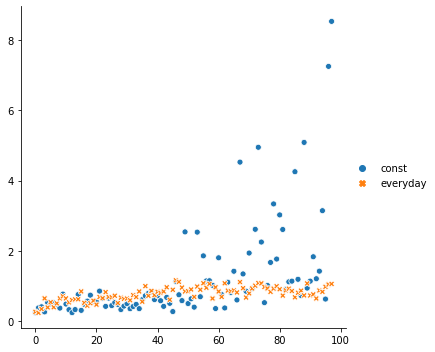

In [31]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k})
sns.relplot(data=df)

In [32]:
df.idxmax()

const       97
everyday    46
dtype: int64

In [33]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [34]:
### Visualization ###

In [35]:
upto = epoch+pd.Timedelta(days=C0.shape[0]-2)
index= pd.date_range(start=epoch, end=upto)

In [36]:
C0.shape

(99,)

In [37]:
def extract(data):
   
    init_inf = pd.DataFrame(data_every.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
    b = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
    q = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
    NI = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
    a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
    d = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
    C = NI.cumsum().shift(periods=1).fillna(0)
    C = pd.DataFrame(np.array([C.iloc[i].values + init_inf[0].values for i in range(C.shape[0])]), index=index)
    NI0 = q*NI
    C0S = NI0.cumsum().shift(periods=1)
    C0S = pd.DataFrame(np.array([C0S.iloc[i].values + C0[0] for i in range(C.shape[0])]), index=index)

    return a, d, b, q, NI, NI0, C, C0S

In [38]:
a_e, d_e, b_e, q_e, NI_e, NI0_e, C_e, C0_e = extract(data_every)

In [39]:
def draw(simulated, real=None, upto=pd.to_datetime('2020-04-26')):
    graph=pd.DataFrame(index=pd.date_range(start=epoch, end=upto))
    median = simulated.median(axis=1)
    upper = simulated.quantile(q=0.75, axis=1)
    lower = simulated.quantile(q=0.25, axis=1)
    if not real is None:
        graph['Real'] = real
    graph['Median'] = median
    graph['Upper'] = upper
    graph['Lower'] = lower
    sns.relplot(kind="line", data=graph, aspect=2)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


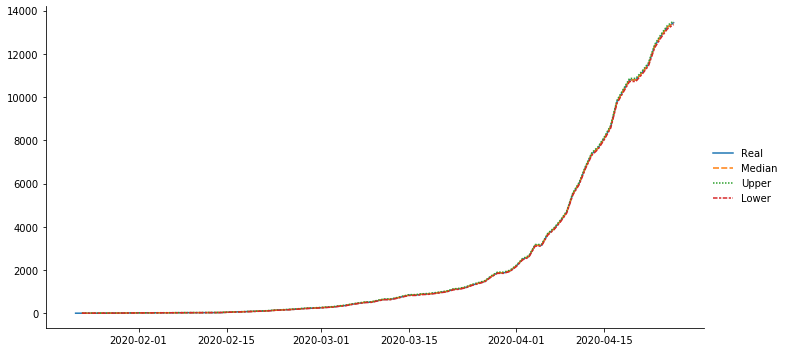

In [40]:
draw(C0_e, real=confirmed[country])

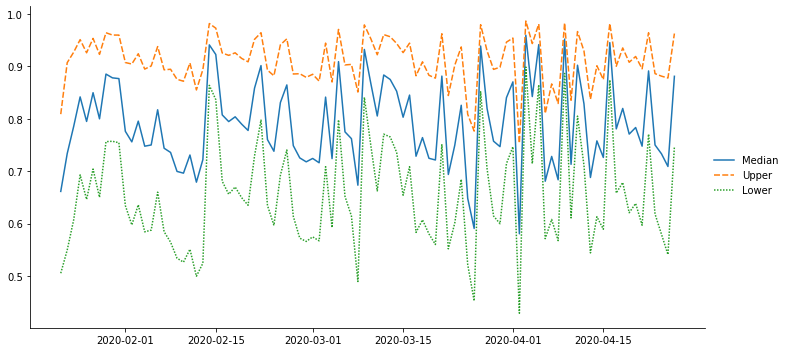

In [41]:
draw(q_e)

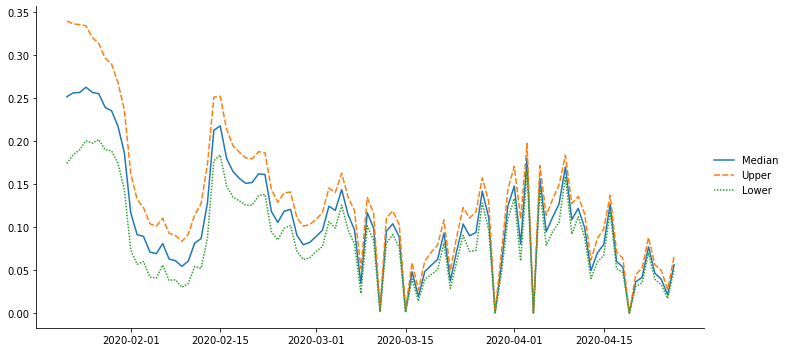

In [42]:
draw(b_e)

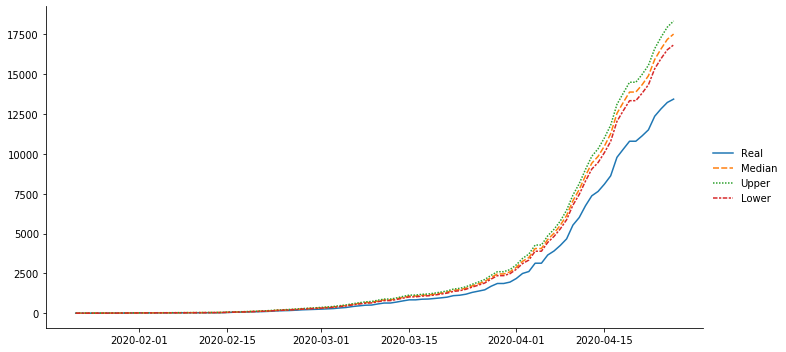

In [43]:
draw(C_e, real=confirmed[country])

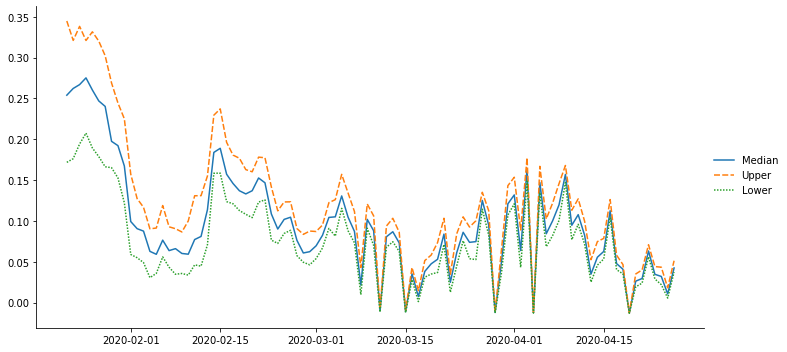

In [44]:
a = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
d = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
beta = pd.DataFrame(np.array([b_e[i].values - a.iloc[i].values - d.iloc[i].values for i in range(len(b_e))]).T, index=b_e.index)
draw(beta)

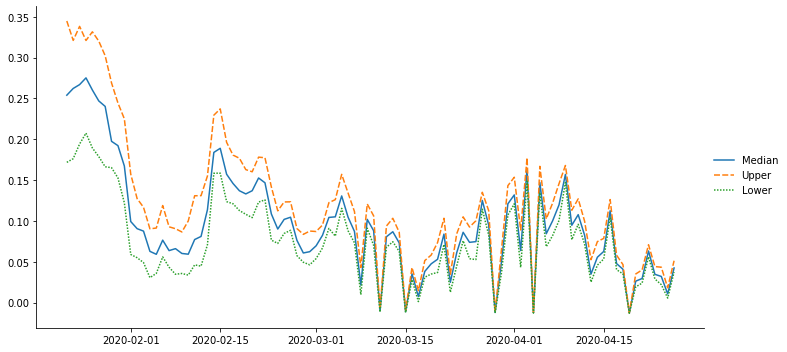

In [45]:
draw(beta)

In [46]:
beta.loc[pd.to_datetime('2020-04-24')].median()

0.03207831938494196

In [47]:
b = data_every.posterior['b'].stack(sample=('chain', 'draw')).sel(b_dim_0=70)
q = data_every.posterior['q'].stack(sample=('chain', 'draw')).sel(q_dim_0=70)

In [48]:
b.values

array([0.18305194, 0.1405242 , 0.13023005, ..., 0.14346904, 0.15683661,
       0.12386942])

In [49]:
q.values

array([0.6228491 , 0.92892756, 0.91922683, ..., 0.98765094, 0.98764045,
       0.99403785])

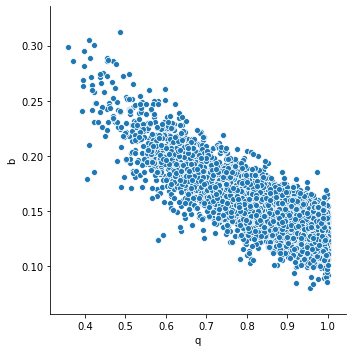

In [50]:
df = pd.DataFrame({'b':b.values, 'q':q.values})
sns.relplot(data=df, x='q', y='b')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99c4ab9990>],
      dtype=object)

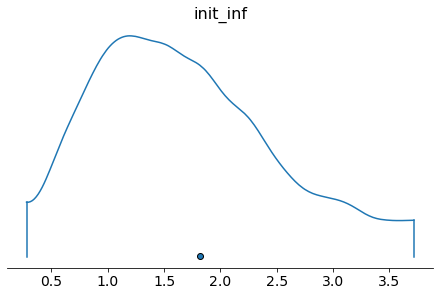

In [51]:
az.plot_density(data_every, var_names=['init_inf'])

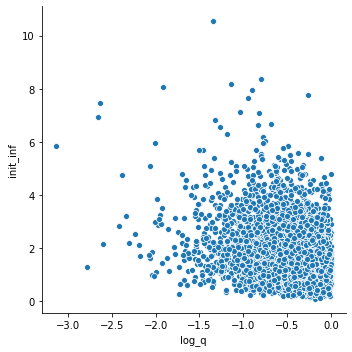

In [52]:
q = data_every.posterior['q'].stack(sample=('chain', 'draw')).sel(q_dim_0=0)
init_inf = data_every.posterior['init_inf'].stack(sample=('chain', 'draw'))
df = pd.DataFrame({'init_inf':init_inf.values, 'log_q':np.log(q.values)})
sns.relplot(data=df, x='log_q', y='init_inf')

In [53]:
sm_sens = pystan.StanModel(file="everyday-sensibility.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da2f787f0c53cd33d14aeaaa13022d94 NOW.


In [54]:
# Train the model and generate samples
inits = 'random'
fit_sens = sm_sens.sampling(data=data, iter=iteration, init=inits)
fit_sens


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_da2f787f0c53cd33d14aeaaa13022d94.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   1.75    0.02   0.85   0.51   1.15   1.62   2.18    3.8   2248    1.0
b_beta     0.05  1.0e-4 5.9e-3   0.04   0.04   0.05   0.05   0.06   3142    1.0
b[1]       0.26  3.9e-3   0.14   0.04   0.16   0.25   0.35   0.58   1276    1.0
b[2]       0.26  3.9e-3   0.13   0.05   0.17   0.25   0.34   0.56   1094   1.01
b[3]       0.26  3.9e-3   0.12   0.07   0.18   0.25   0.33   0.54    972   1.01
b[4]       0.27  3.3e-3   0.11   0.09   0.19   0.26   0.33   0.52   1118    1.0
b[5]       0.26  3.0e-3    0.1   0.09   0.19   0.25   0.32   0.48   1094    1.0
b[6]       0.26  2.7e-3   0.09   0.11    0.2   0.26   0.32   0.47   1114    1.0
b[7]       0.25  2.5e-3   0.09   0.09   0.19   0.24

In [55]:
data_sens = az.from_pystan(fit_sens, log_likelihood='log_lik')

In [56]:
init_inf_sens = pd.DataFrame(data_sens.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
b_sens = pd.DataFrame(data_sens.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sens = pd.DataFrame(data_sens.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)



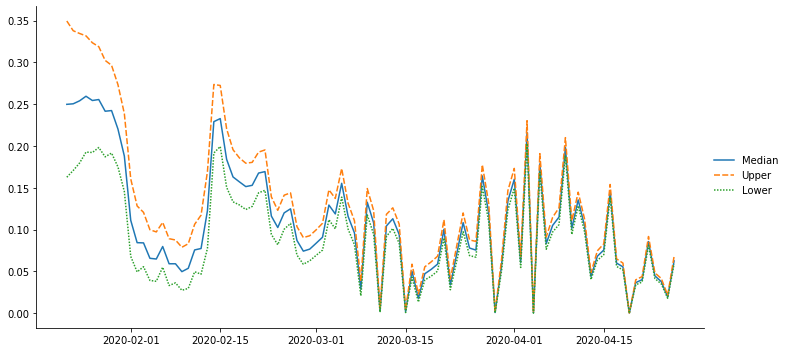

In [57]:
draw(b_sens)

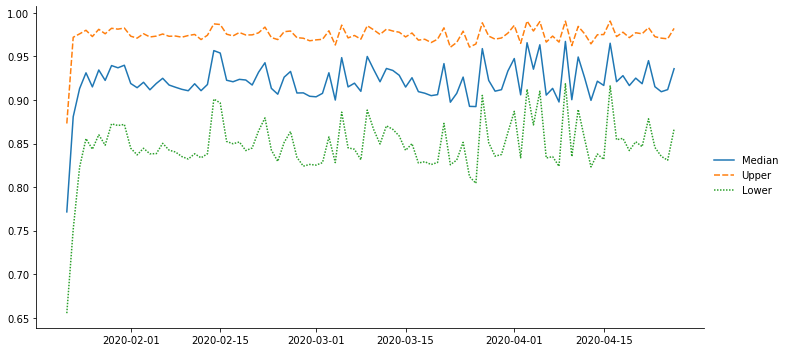

In [58]:
draw(q_sens)

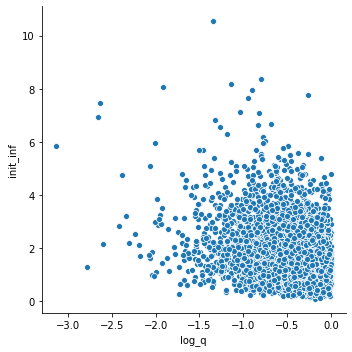

In [59]:
df = pd.DataFrame({'init_inf':init_inf.values, 'log_q':np.log(q.values)})
sns.relplot(data=df, x='log_q', y='init_inf')

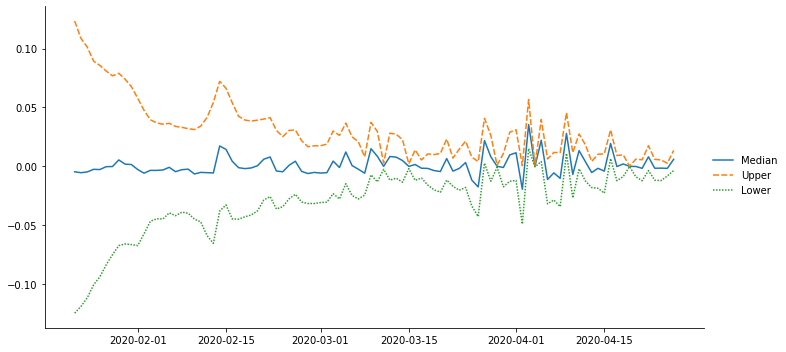

In [60]:
draw(b_sens-b_e)

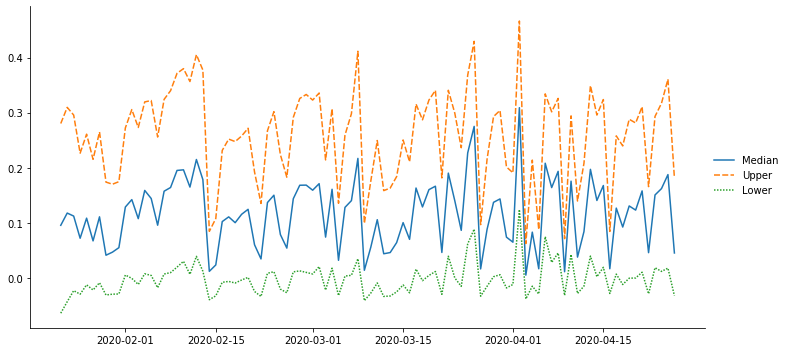

In [61]:
draw(q_sens-q_e)

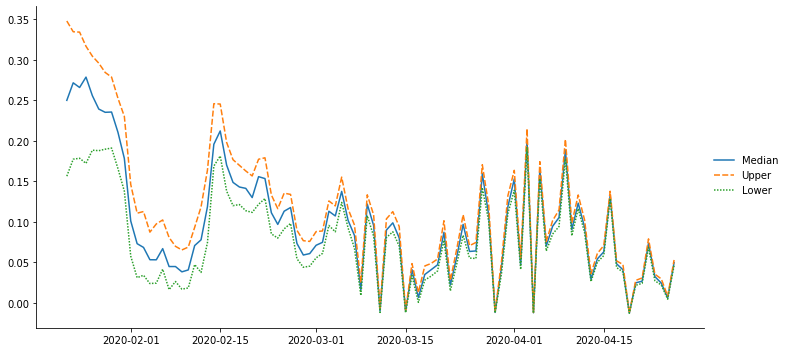

In [62]:
a_s = pd.DataFrame(data_sens.posterior['a'].stack(sample=('chain', 'draw')).values)
d_s = pd.DataFrame(data_sens.posterior['d'].stack(sample=('chain', 'draw')).values)
beta_s = pd.DataFrame(np.array([b_sens[i].values - a_s.iloc[i].values - d_s.iloc[i].values for i in range(len(b_sens))]).T, index=b_sens.index)
draw(beta_s)

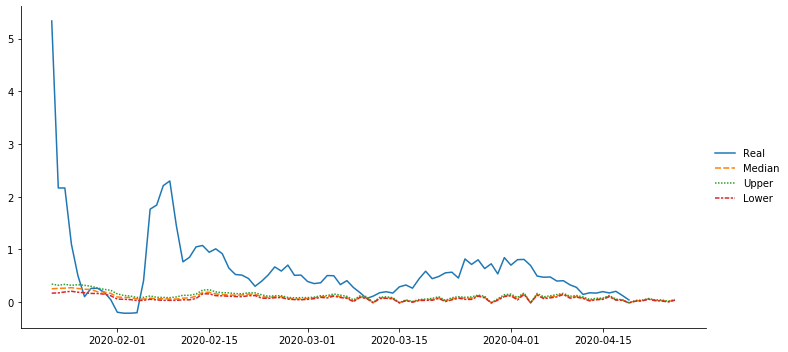

In [75]:
infected = (confirmed-recovered)[country]
r=infected.shift(-5)/infected-1
draw(beta, real=r.shift(-5))

In [64]:
df = pd.DataFrame()
df['data']=infected
df['shifted']=infected.shift(-5)

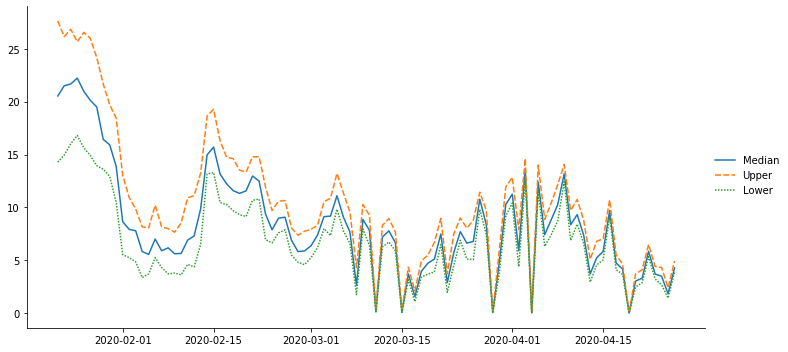

In [74]:
R0 = pd.DataFrame(np.array([b_e[i].values / (a.iloc[i].values + d.iloc[i].values) for i in range(len(b_e))]).T, index=b_e.index)
draw(R0)